In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.mvo_opt import MVOOptimizer

%load_ext autoreload
%autoreload 2

In [2]:
sector_tickers = [
    "XLF",  # Financials
    "XLK",  # Technology
    "XLV",  # Health Care
    "XLY",  # Consumer Discretionary
    "XLP",  # Consumer Staples
    "XLE",  # Energy
    "XLI",  # Industrials
    "XLU",  # Utilities
    "XLB",  # Materials
    "XLRE",  # Real Estate
    "XLC",  # Communication Services
]

# import data from csv
df_ret = pd.read_parquet("../data/returns.parquet")
df_prices = pd.read_parquet("../data/prices.parquet")
df_vol = pd.read_parquet("../data/vola.parquet")

In [99]:
# Test different lookback periods
lookback_periods = [10, 30, 60, 90, 120, 150]
results = []

for lookback in lookback_periods:
    optimizer = MVOOptimizer(tickers=sector_tickers, lookback=lookback)
    portfolio_df = optimizer.backtest(
        df_ret, df_prices, start_date="2019-01-02", end_date="2021-12-31"
    )
    portfolio_df['lookback'] = lookback
    results.append(portfolio_df)

# Combine all results
final_df = pd.concat(results, axis=0)

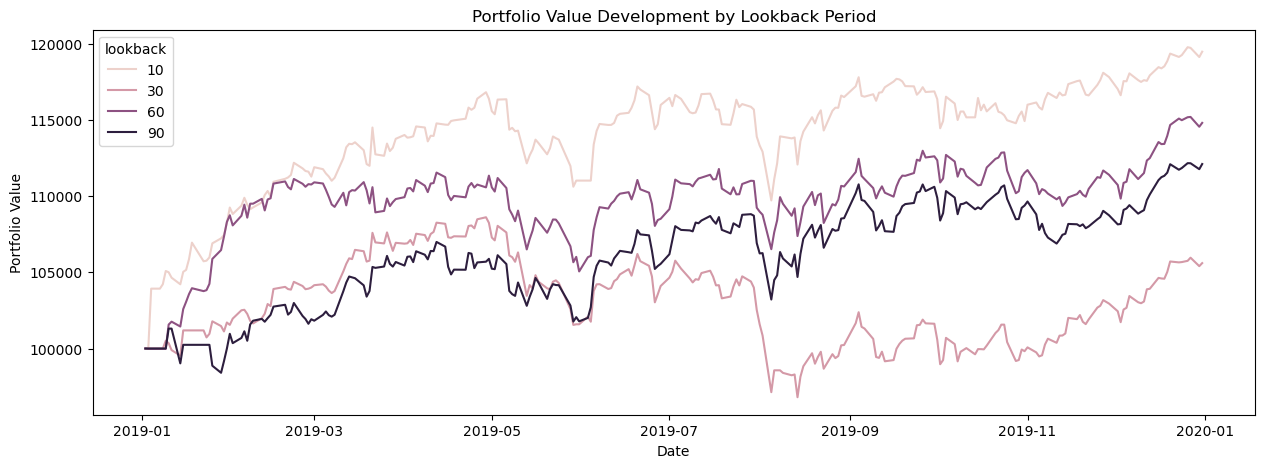

In [ ]:
# PLOT Portfolio Value Development
plt.figure(figsize=(15, 5))
sns.lineplot(data=final_df, x='date', y='portfolio_value', hue='lookback')
plt.title('Portfolio Value Development by Lookback Period')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()


In [101]:
# Calculate metrics for each lookback period

def calc_metrics(
    portfolio_values,
    risk_free_rate: float = 0,
):
    """
    Calculate portfolio performance metrics.

    Args:
        portfolio_values: Array of portfolio values over time
        risk_free_rate: Annual risk-free rate (default: 2%)

    Returns:
        Dictionary containing various portfolio metrics
    """
    # Convert to numpy array if needed
    if isinstance(portfolio_values, (list, pd.Series)):
        portfolio_values = np.array(portfolio_values)

    # Calculate daily returns
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]

    # Annual return (assuming 252 trading days)
    annual_return = (portfolio_values[-1] / portfolio_values[0]) ** (
        252 / len(portfolio_values)
    ) - 1

    # Cumulative returns
    cumulative_return = (portfolio_values[-1] / portfolio_values[0]) - 1

    # Annual volatility
    annual_volatility = np.std(daily_returns) * np.sqrt(252)

    # Sharpe ratio
    excess_returns = daily_returns - risk_free_rate / 252
    sharpe_ratio = np.sqrt(252) * np.mean(excess_returns) / np.std(daily_returns)

    # Maximum drawdown
    rolling_max = np.maximum.accumulate(portfolio_values)
    drawdowns = (portfolio_values - rolling_max) / rolling_max
    max_drawdown = np.min(drawdowns)

    # Calmar ratio
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown != 0 else 0

    # Sortino ratio (using negative returns only)
    negative_returns = daily_returns[daily_returns < 0]
    sortino_ratio = (
        np.sqrt(252) * np.mean(excess_returns) / np.std(negative_returns)
        if len(negative_returns) > 0
        else 0
    )

    # Omega ratio
    threshold = risk_free_rate / 252
    positive_returns = daily_returns[daily_returns > threshold]
    negative_returns = daily_returns[daily_returns <= threshold]
    omega_ratio = (
        np.sum(positive_returns - threshold) / abs(np.sum(negative_returns - threshold))
        if len(negative_returns) > 0
        else float("inf")
    )

    # Skewness and Kurtosis
    skew = pd.Series(daily_returns).skew()
    kurtosis = pd.Series(daily_returns).kurtosis()

    # Tail ratio (95th percentile / 5th percentile)
    tail_ratio = np.percentile(daily_returns, 95) / abs(np.percentile(daily_returns, 5))

    # Value at Risk (95%)
    var = np.percentile(daily_returns, 5)

    # Portfolio turnover (average daily change in weights)
    daily_change = np.mean(np.abs(np.diff(portfolio_values) / portfolio_values[:-1]))

    # Stability (inverse of volatility)
    stability = 1 / (1 + annual_volatility)

    return {
        "Annual return": annual_return,
        "Cumulative returns": cumulative_return,
        "Annual volatility": annual_volatility,
        "Sharpe ratio": sharpe_ratio,
        "Calmar ratio": calmar_ratio,
        "Stability": stability,
        "Max drawdown": max_drawdown,
        "Omega ratio": omega_ratio,
        "Sortino ratio": sortino_ratio,
        "Skew": skew,
        "Kurtosis": kurtosis,
        "Tail ratio": tail_ratio,
        "Daily value at risk": var,
        "Portfolio turnover": daily_change,
    }


metrics_results = []
for lookback in lookback_periods:
    portfolio_values = final_df[final_df['lookback'] == lookback]['portfolio_value'].values
    metrics = calc_metrics(portfolio_values)
    metrics['lookback'] = lookback
    metrics_results.append(metrics)

# Convert metrics to DataFrame for better visualization
metrics_df = pd.DataFrame(metrics_results)

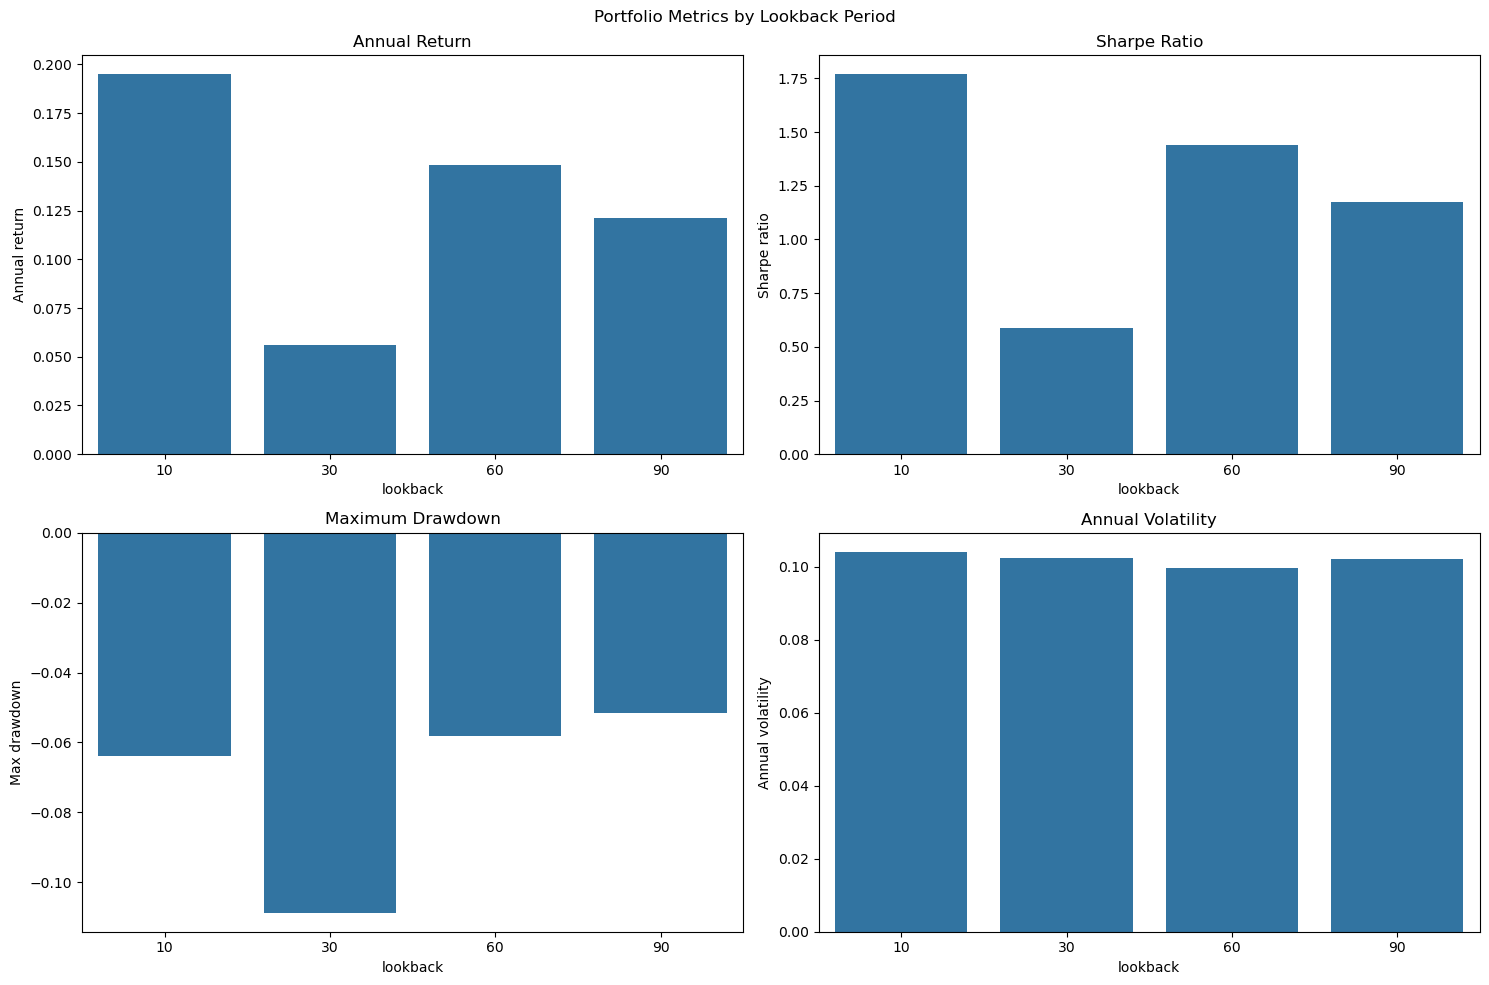


Detailed Metrics by Lookback Period:
 Annual return  Cumulative returns  Annual volatility  Sharpe ratio  Calmar ratio  Stability  Max drawdown  Omega ratio  Sortino ratio      Skew  Kurtosis  Tail ratio  Daily value at risk  Portfolio turnover  lookback
      0.194883            0.194883           0.104149      1.768944      3.053089   0.905675     -0.063831     1.392549       2.412733  0.348438  6.559935    0.971952            -0.009630            0.004456        10
      0.056073            0.056073           0.102492      0.585949      0.515468   0.907036     -0.108781     1.112931       0.693773 -1.004169  5.363095    0.802032            -0.010737            0.004459        30
      0.148147            0.148147           0.099773      1.440526      2.546084   0.909279     -0.058186     1.268944       1.926684 -0.596120  1.165365    0.868447            -0.010561            0.004812        60
      0.121130            0.121130           0.102136      1.175361      2.352884   0.9073

In [102]:
# Plot key metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Portfolio Metrics by Lookback Period')

# Annual Return
sns.barplot(data=metrics_df, x='lookback', y='Annual return', ax=axes[0,0])
axes[0,0].set_title('Annual Return')

# Sharpe Ratio
sns.barplot(data=metrics_df, x='lookback', y='Sharpe ratio', ax=axes[0,1])
axes[0,1].set_title('Sharpe Ratio')

# Max Drawdown
sns.barplot(data=metrics_df, x='lookback', y='Max drawdown', ax=axes[1,0])
axes[1,0].set_title('Maximum Drawdown')

# Volatility
sns.barplot(data=metrics_df, x='lookback', y='Annual volatility', ax=axes[1,1])
axes[1,1].set_title('Annual Volatility')

plt.tight_layout()
plt.show()

# Print detailed metrics
print("\nDetailed Metrics by Lookback Period:")
print(metrics_df.to_string(index=False))